# Task 1: Autoencoder

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import sys
import subprocess

from torchvision import datasets, transforms
from torch.utils.data import random_split, SequentialSampler
from torch.optim import Adam

subprocess.check_call([sys.executable, "-m", "pip", "install", "milankalkenings==0.1.37"])

from milankalkenings import *

In [24]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.rect = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor):
        x = self.rect(self.conv1(x))
        x = self.rect(self.conv2(x))
        x = self.rect(self.conv3(x))
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.rect = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.tconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.tconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=2, padding=1)

    def forward(self, x: torch.Tensor):
        x = self.rect(self.tconv1(x))
        x = self.rect(self.tconv2(x))
        x = self.rect(self.tconv3(x))
        x = self.rect(self.conv1(x))
        return x


class Classifier(Module):
    def __init__(self, encoder: Encoder, n_classes: int):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.flatten = nn.Flatten()
        self.cls_head = nn.Linear(in_features=128, out_features=n_classes)
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                x: Union[torch.Tensor, List[torch.Tensor]],
                y: Union[torch.Tensor, List[torch.Tensor]]) -> ModuleOutput:
        encoding = self.encoder(x)
        encoding_flat = self.flatten(encoding)
        scores = self.cls_head(encoding_flat)
        loss = self.ce_loss(scores, y)
        return {"scores": scores, "loss": loss}


class AutoEncoder(Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.mse_loss = nn.MSELoss()

    # doesn't need y, included in implementation for milankalkenings-0.1.33-trainer interface
    def forward(self,
                x: Union[torch.Tensor, List[torch.Tensor]],
                y: Union[torch.Tensor, List[torch.Tensor]]) -> ModuleOutput:
        encoding = self.encoder(x)
        scores = self.decoder(encoding)
        loss = self.mse_loss(scores, x)
        return {"loss": loss, "scores": scores, "encoding": encoding}


In [ ]:
# hyperparameters
# general
device = "cuda"
batch_size = 128
batch_size_test = 1
optimizer_class = Adam

# checkpoint paths
monitoring_path = "/content/drive/MyDrive/autoencoder/monitoring"
check_cifar100_rec_initial = monitoring_path + "/cifar100_rec_initial.pkl"
check_cifar100_rec_running = monitoring_path + "/cifar100_rec_running.pkl"
check_cifar100_rec_final = monitoring_path + "/cifar100_rec_final.pkl"
check_cifar100_cls_initial = monitoring_path + "/cifar100_rec_initial.pkl"
check_cifar100_cls_running = monitoring_path + "/cifar100_rec_running.pkl"
check_cifar100_cls_final = monitoring_path + "/cifar100_rec_final.pkl"
check_mnist_rec_initial = monitoring_path + "/mnist_rec_initial.pkl"
check_mnist_rec_running = monitoring_path + "/mnist_rec_running.pkl"
check_mnist_rec_final = monitoring_path + "/mnist_rec_final.pkl"
check_mnist_cls_initial = monitoring_path + "/mnist_rec_initial.pkl"
check_mnist_cls_running = monitoring_path + "/mnist_rec_running.pkl"
check_mnist_cls_final = monitoring_path + "/mnist_rec_final.pkl"

# data preprocessing
data_path = "/content/drive/MyDrive/autoencoder/data"
root_cifar100 = data_path + "/cifar100"
root_mnist = data_path + "/mnist"
train_trans_cifar100 = transforms.Compose([transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()])
test_trans_cifar100 = transforms.Compose([transforms.ToTensor()])
train_trans_mnist = transforms.Compose([transforms.Resize((32, 32)),
                                        transforms.Grayscale(num_output_channels=3),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()])
test_trans_mnist = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor()])

# rec training
n_epochs_rec_cifar100 = 100
max_es_violations_rec_cifar100 = 5
lr_rec_cifar100 = 0.001
n_epochs_rec_mnist = 100
max_es_violations_rec_mnist = 5
lr_rec_mnist = 0.001

# cls training
n_epochs_cls_cifar100 = 5
max_es_violations_cls_cifar100 = 5
lr_cls_cifar100 = 0.001
n_epochs_cls_mnist = 5
max_es_violations_cls_mnist = 5
lr_cls_mnist = 0.001

# loaders
data_cifar100 = ImageClsDataset(dataset_class=datasets.CIFAR100,
                                save_dir=root_cifar100,
                                train_trans=train_trans_cifar100,
                                val_trans=test_trans_cifar100,
                                test_trans=test_trans_cifar100)
data_mnist = ImageClsDataset(dataset_class=datasets.MNIST,
                             save_dir=root_mnist,
                             train_trans=train_trans_mnist,
                             val_trans=test_trans_mnist,
                             test_trans=test_trans_mnist)

loader_train_cifar100, loader_val_cifar100, loader_test_cifar100 = data_cifar100.create_loaders(batch_size_train=batch_size,
                                                                                                batch_size_val=batch_size,
                                                                                                batch_size_test=batch_size_test)
loader_train_mnist, loader_val_mnist, loader_test_mnist = data_mnist.create_loaders(batch_size_train=batch_size,
                                                                                    batch_size_val=batch_size,
                                                                                    batch_size_test=batch_size_test)

# training reconstruction on CIFAR100

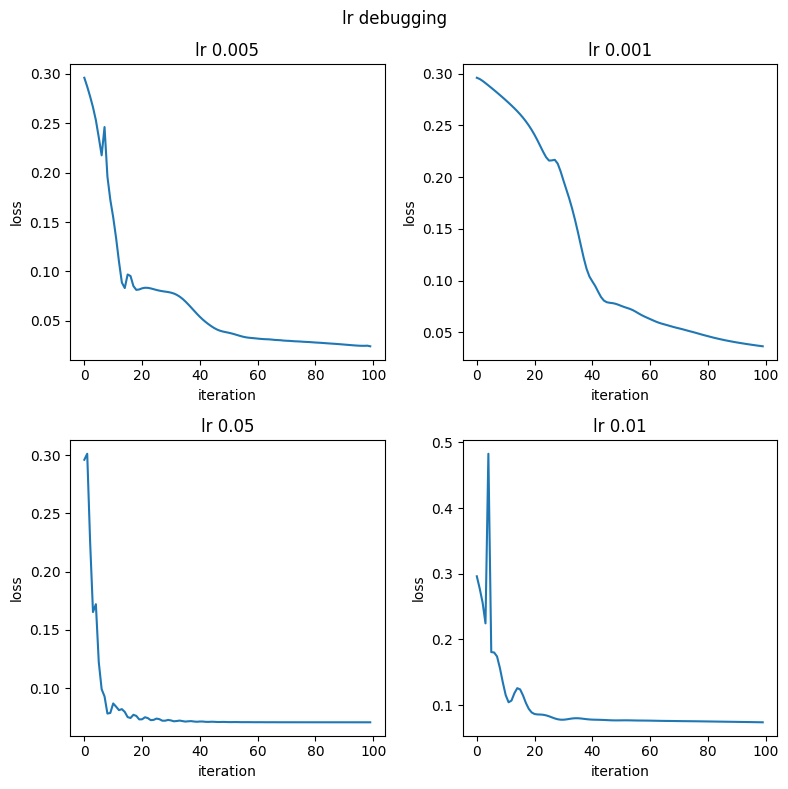

In [ ]:
#autoencoder_cifar100 = AutoEncoder()
#save_secure(module=autoencoder_cifar100, file=check_cifar100_rec_initial)
autoencoder_cifar100 = load_secure(file=check_cifar100_rec_initial).to(device)

trainer_rec_cifar100 = Trainer(module=autoencoder_cifar100,
                               loader_train=loader_train_cifar100,
                               loader_val=loader_val_cifar100,
                               loader_test=loader_test_cifar100,
                               checkpoint_final=check_cifar100_rec_final,
                               checkpoint_running=check_cifar100_rec_final,
                               optimizer_class=optimizer_class,
                               device=device)

trainer_rec_cifar100.determine_initial_lr(module=autoencoder_cifar100, n_iters=100, lr_candidates=[0.005, 0.001, 0.05, 0.01], batch_debug=next(iter(loader_train_cifar100)), save_file=monitoring_path + "lr determination")

In [ ]:
autoencoder_cifar100, losses_train_rec_cifar100, losses_val_rec_cifar100 = trainer_rec_cifar100.train(
    n_epochs=n_epochs_rec_cifar100,
    lrs=[lr_rec_cifar100] * n_epochs_rec_cifar100,
    early_stopping_max_violations=max_es_violations_rec_cifar100)

eval loss val 0.29947352409362793 eval loss train 0.3003104329109192
training epoch 1
eval loss val 0.01901611126959324 eval loss train 0.0190106313675642
loss improvement achieved, final checkpoint updated
training epoch 2
eval loss val 0.01655927672982216 eval loss train 0.016573715955018997
loss improvement achieved, final checkpoint updated
training epoch 3
eval loss val 0.013361544348299503 eval loss train 0.013352432288229465
loss improvement achieved, final checkpoint updated
training epoch 4
eval loss val 0.010439588688313961 eval loss train 0.010411667637526989
loss improvement achieved, final checkpoint updated
training epoch 5
eval loss val 0.009902558289468288 eval loss train 0.009876919910311699
loss improvement achieved, final checkpoint updated
training epoch 6
eval loss val 0.009620964527130127 eval loss train 0.009598790667951107
loss improvement achieved, final checkpoint updated
training epoch 7
eval loss val 0.009284915402531624 eval loss train 0.00927028153091669
l

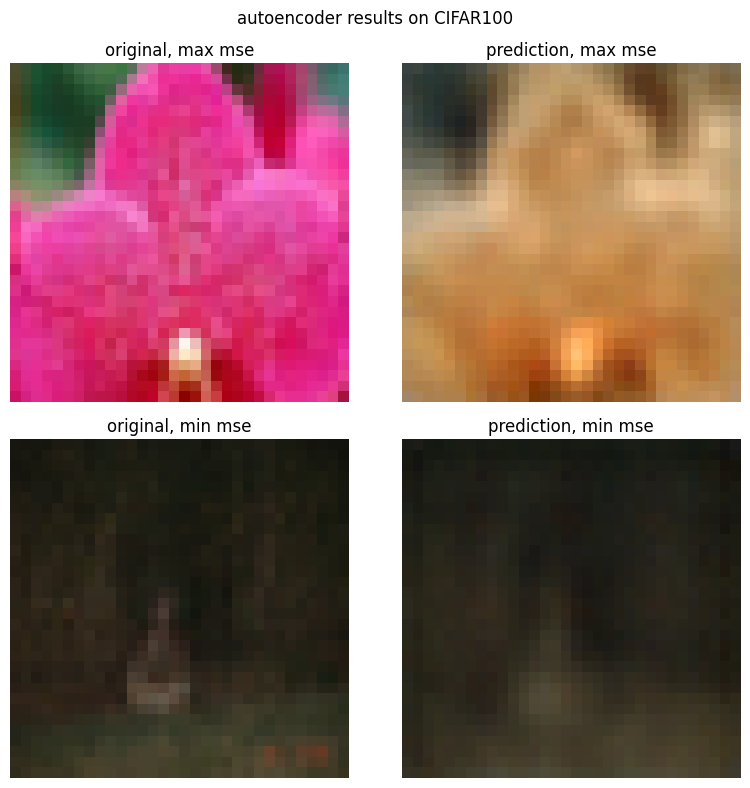

In [ ]:
# display original and reconstructed image for max AND min mse observation
# loader_test_cifar100 has batch_size = 1 -> loss per batch = loss per obs (and has sequential sampler)
test_obs_mses = trainer_rec_cifar100.loss_epoch_eval_per_batch(module=autoencoder_cifar100, loader_eval=loader_test_cifar100)
max_mse_obs_id = torch.argmax(test_obs_mses)
max_mse_img = data_cifar100.test_dataset[max_mse_obs_id][0]
max_mse_pred = autoencoder_cifar100(x=max_mse_img.to(device), y=None)["scores"]

min_mse_obs_id = torch.argmin(test_obs_mses)
min_mse_img = data_cifar100.test_dataset[min_mse_obs_id][0]
min_mse_pred = autoencoder_cifar100(x=min_mse_img.to(device), y=None)["scores"]
images_subplot(images=[max_mse_img, max_mse_pred.to("cpu"), min_mse_img, min_mse_pred.to("cpu")],
               title="autoencoder results on CIFAR100", subplot_titles=["original, max mse", "prediction, max mse", "original, min mse", "prediction, min mse"], save_file=monitoring_path + "/cifar100_prediction")

# training reconstruction on MNIST

In [ ]:
# do the same on mnist
# autoencoder_mnist = AutoEncoder()
# save_secure(module=autoencoder_mnist, file=check_mnist_rec_initial)
autoencoder_mnist = load_secure(file=check_mnist_rec_initial).to(device)
trainer_rec_mnist = Trainer(module=autoencoder_mnist,
                            loader_train=loader_train_mnist,
                            loader_val=loader_val_mnist,
                            loader_test=loader_test_mnist,
                            checkpoint_final=check_mnist_rec_final,
                            checkpoint_running=check_mnist_rec_final,
                            optimizer_class=Adam,
                            device=device)

autoencoder_mnist, losses_train_rec_mnist, losses_val_rec_mnist = trainer_rec_mnist.train(
    n_epochs=n_epochs_rec_mnist,
    lrs=[lr_rec_mnist] * n_epochs_rec_mnist,
    early_stopping_max_violations=max_es_violations_rec_mnist)

eval loss val 0.09086303412914276 eval loss train 0.09052157402038574
training epoch 1
eval loss val 0.0043305037543177605 eval loss train 0.00430345069617033
loss improvement achieved, final checkpoint updated
training epoch 2
eval loss val 0.002957066986709833 eval loss train 0.0029396130703389645
loss improvement achieved, final checkpoint updated
training epoch 3
eval loss val 0.002545685274526477 eval loss train 0.002528007375076413
loss improvement achieved, final checkpoint updated
training epoch 4
eval loss val 0.0023934103082865477 eval loss train 0.002375238109380007
loss improvement achieved, final checkpoint updated
training epoch 5
eval loss val 0.002224999014288187 eval loss train 0.0022066133096814156
loss improvement achieved, final checkpoint updated
training epoch 6
eval loss val 0.0021213514264672995 eval loss train 0.0021030819043517113
loss improvement achieved, final checkpoint updated
training epoch 7
eval loss val 0.002028543269261718 eval loss train 0.002010753

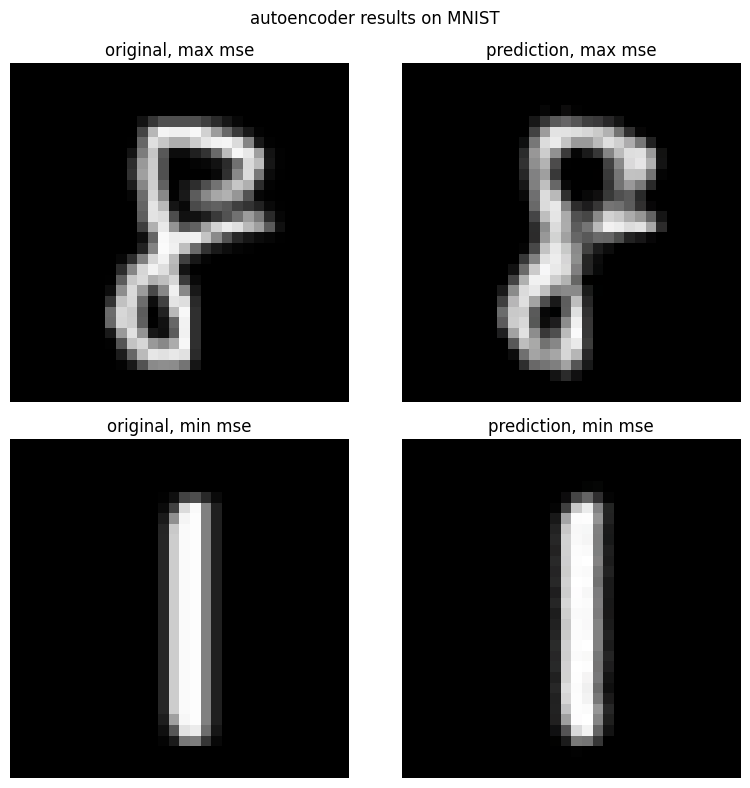

In [ ]:
# loader_test_mnist has batch_size = 1 -> loss per batch = loss per obs (and has sequential sampler)
test_obs_mses = trainer_rec_mnist.loss_epoch_eval_per_batch(module=autoencoder_mnist, loader_eval=loader_test_mnist)
max_mse_obs_id = torch.argmax(test_obs_mses)
max_mse_img = data_mnist.test_dataset[max_mse_obs_id][0]
max_mse_pred = autoencoder_mnist(x=max_mse_img.to(device), y=None)["scores"]

min_mse_obs_id = torch.argmin(test_obs_mses)
min_mse_img = data_mnist.test_dataset[min_mse_obs_id][0]
min_mse_pred = autoencoder_mnist(x=min_mse_img.to(device), y=None)["scores"]
images_subplot(images=[max_mse_img, max_mse_pred.to("cpu"), min_mse_img, min_mse_pred.to("cpu")],
               title="autoencoder results on MNIST", subplot_titles=["original, max mse", "prediction, max mse", "original, min mse", "prediction, min mse"], save_file=monitoring_path + "/mnist_prediction")

# general reconstruction ability

In [ ]:
autoencoder_random = load_secure(file=check_cifar100_cls_initial).to(device)
mse_untrained_on_cifar100 = trainer_rec_cifar100.loss_epoch_eval(module=autoencoder_random, 
                                                                 loader_eval=loader_test_cifar100)

mse_untrained_on_mnist = trainer_rec_cifar100.loss_epoch_eval(module=autoencoder_random, 
                                                             loader_eval=loader_test_mnist)

mse_cross_on_mnist = trainer_rec_cifar100.loss_epoch_eval(module=autoencoder_cifar100, 
                                                             loader_eval=loader_test_mnist)
mse_cross_on_cifar100 = trainer_rec_mnist.loss_epoch_eval(module=autoencoder_mnist, 
                                                          loader_eval=loader_test_cifar100)

mse_cifar100 = trainer_rec_cifar100.loss_epoch_eval(module=autoencoder_cifar100, 
                                                    loader_eval=loader_test_cifar100)
mse_mnist = trainer_rec_mnist.loss_epoch_eval(module=autoencoder_mnist, 
                                              loader_eval=loader_test_mnist)


print("mean mse on cifar100 after initialization:", mse_untrained_on_cifar100)
print("mean mse on cifar100 after mnist training:", mse_cross_on_cifar100)
print("mean mse on cifar100 after cifar100 training:", mse_cifar100)

print("mean mse on mnist after initialization:", mse_untrained_on_mnist)
print("mean mse on mnist after cifar100 training:", mse_cross_on_mnist)
print("mean mse on mnist after mnist training:", mse_mnist)

mean mse on cifar100 after initialization: 0.3017454445362091
mean mse on cifar100 after mnist training: 0.09275778383016586
mean mse on cifar100 after cifar100 training: 0.007397091016173363
mean mse on mnist after initialization: 0.10269580036401749
mean mse on mnist after cifar100 training: 0.009012334980070591
mean mse on mnist after mnist training: 0.0010934886522591114


# Using a pretrained encoder for classification

In [ ]:
autoencoder_random = load_secure(file=check_cifar100_cls_initial).to(device)
classifier_random = Classifier(encoder=autoencoder_random.encoder, n_classes=100)
save_secure(module=classifier_random, file=check_cifar100_cls_initial)
classifier_random = load_secure(file=check_cifar100_cls_initial).to(device)
trainer_cls_random = Trainer(module=classifier_random, 
                             loader_train=loader_train_cifar100, 
                             loader_val=loader_val_cifar100, 
                             loader_test=loader_test_cifar100, 
                             optimizer_class=optimizer_class, 
                             device=device, 
                             checkpoint_running=check_cifar100_cls_running, 
                             checkpoint_final=check_cifar100_cls_final)
trainer_cls_random.train(n_epochs=n_epochs_cls_cifar100, 
                         lrs=[lr_cls_cifar100]*n_epochs_cls_cifar100, 
                         early_stopping_max_violations=max_es_violations_cls_cifar100)

eval loss val 4.606760025024414 eval loss train 4.606176853179932
training epoch 1
eval loss val 3.88308048248291 eval loss train 3.8584342002868652
loss improvement achieved, final checkpoint updated
training epoch 2
eval loss val 3.710446834564209 eval loss train 3.653135061264038
loss improvement achieved, final checkpoint updated
training epoch 3
eval loss val 3.60099196434021 eval loss train 3.5148465633392334
loss improvement achieved, final checkpoint updated
training epoch 4
eval loss val 3.52231502532959 eval loss train 3.4157464504241943
loss improvement achieved, final checkpoint updated
training epoch 5
eval loss val 3.4619290828704834 eval loss train 3.3368680477142334
loss improvement achieved, final checkpoint updated


(Classifier(
   (encoder): Encoder(
     (rect): ReLU()
     (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (cls_head): Linear(in_features=128, out_features=100, bias=True)
   (ce_loss): CrossEntropyLoss()
 ),
 [4.606176853179932,
  3.8584342002868652,
  3.653135061264038,
  3.5148465633392334,
  3.4157464504241943,
  3.3368680477142334],
 [4.606760025024414,
  3.88308048248291,
  3.710446834564209,
  3.60099196434021,
  3.52231502532959,
  3.4619290828704834])

In [ ]:
autoencoder_cifar100 = load_secure(file=check_cifar100_rec_final)
classifier_pretrained = load_secure(file=check_cifar100_cls_initial).to(device)
classifier_pretrained.encoder = autoencoder_cifar100.encoder 
trainer_cls_pretrained = Trainer(module=classifier_pretrained, 
                                 loader_train=loader_train_cifar100, 
                                 loader_val=loader_val_cifar100, 
                                 loader_test=loader_test_cifar100, 
                                 optimizer_class=optimizer_class, 
                                 device=device, 
                                 checkpoint_running=check_cifar100_cls_running, 
                                 checkpoint_final=check_cifar100_cls_final)
trainer_cls_pretrained.train(n_epochs=n_epochs_cls_cifar100, 
                             lrs=[lr_cls_cifar100]*n_epochs_cls_cifar100, 
                             early_stopping_max_violations=max_es_violations_cls_cifar100)

eval loss val 5.153634548187256 eval loss train 5.164750099182129
training epoch 1
eval loss val 3.616201162338257 eval loss train 3.5674405097961426
loss improvement achieved, final checkpoint updated
training epoch 2
eval loss val 3.4519553184509277 eval loss train 3.3740720748901367
loss improvement achieved, final checkpoint updated
training epoch 3
eval loss val 3.367218017578125 eval loss train 3.2644710540771484
loss improvement achieved, final checkpoint updated
training epoch 4
eval loss val 3.307884454727173 eval loss train 3.185678243637085
loss improvement achieved, final checkpoint updated
training epoch 5
eval loss val 3.2651939392089844 eval loss train 3.126099109649658
loss improvement achieved, final checkpoint updated


(Classifier(
   (encoder): Encoder(
     (rect): ReLU()
     (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (cls_head): Linear(in_features=128, out_features=100, bias=True)
   (ce_loss): CrossEntropyLoss()
 ),
 [5.164750099182129,
  3.5674405097961426,
  3.3740720748901367,
  3.2644710540771484,
  3.185678243637085,
  3.126099109649658],
 [5.153634548187256,
  3.616201162338257,
  3.4519553184509277,
  3.367218017578125,
  3.307884454727173,
  3.2651939392089844])

# conclusions
- if an autoencoder is trained to reconstruct instances of data set X, it is likely to achieve good results on reconstructing instances of data set Y, if X and Y are similar enough. autoencoders can (to some degree) learn *general reconstruction abilities* on equal data types
- pretraining an *encoder* within an autoencoder, and later using it for as a feature learner in a classifier can speed up the training process, because the encoder already learned how to extract general features in the given data
- a well trained autoencoder can be used to generate new data points that still contain the data signal, but add further noise (similar to data augmentation)